# About

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The purpose is to learn about historical *ex ante* real interest rates in the US.

In [1]:
import numpy as np
import matplotlib.dates as dts
import pandas as pd
import fredpy as fp
import requests
import matplotlib.pyplot as plt
import mock
from openpyxl.reader import excel

plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Import forecast data

In [2]:
# url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/medianlevel.xls?la=en"
# r = requests.get(url,verify=False)
# with open("../xls/medianLevel.xls", "wb") as code:
#     code.write(r.content)

In [3]:
# deflator_forecasts = pd.read_excel('../xls/medianLevel.xls',sheet_name = 'PGDP')

with mock.patch.object(excel.ExcelReader, 'read_properties', lambda self: None):
    deflator_forecasts = pd.read_excel('https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/survey-of-professional-forecasters/historical-data/medianlevel.xlsx?la=en&hash=BA7A2D423DA7F07CCEBE928ED48A1941', dtype={'YEAR': str, 'QUARTER': str},sheet_name='PGDP')


deflator_forecasts=deflator_forecasts.interpolate()
deflator_forecasts = deflator_forecasts.iloc[5:]

/Users/bcjenkin/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## GDP deflator inflation forecasts

In [4]:
# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(deflator_forecasts.index):
    year =int(deflator_forecasts.iloc[i]['YEAR'])
    quart=int(deflator_forecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(400*(deflator_forecasts.iloc[i]['PGDP3']/deflator_forecasts.iloc[i]['PGDP2']-1))
    forecast_2q.append(200*(deflator_forecasts.iloc[i]['PGDP4']/deflator_forecasts.iloc[i]['PGDP2']-1))
    forecast_1y.append(100*(deflator_forecasts.iloc[i]['PGDP6']/deflator_forecasts.iloc[i]['PGDP2']-1))

# Update the FRED instances

defl_forecast_1q = fp.to_fred_series(data = forecast_1q,dates = dates,frequency='Quarterly')
defl_forecast_2q = fp.to_fred_series(data = forecast_2q,dates = dates,frequency='Quarterly')
defl_forecast_1y = fp.to_fred_series(data = forecast_1y,dates = dates,frequency='Quarterly')

deflator_frame = pd.DataFrame({'deflator inflation - 3mo forecast':defl_forecast_1q.data,
                          'deflator inflation - 6mo forecast':defl_forecast_2q.data,
                          'deflator inflation - 1yr forecast':defl_forecast_1y.data})

## Actual data

In [5]:
interest3mo = fp.series('TB3MS').as_frequency('Q')
interest6mo = fp.series('TB6MS').as_frequency('Q')
interest1yr = fp.series('GS1').as_frequency('Q')

interest3mo,interest6mo,interest1yr = fp.window_equalize([interest3mo,interest6mo,interest1yr])

interest_frame = pd.DataFrame({'nominal interest - 3mo':interest3mo.data,
                             'nominal interest - 6mo':interest6mo.data,
                             'nominal interest - 1yr':interest1yr.data})

In [6]:
defl_3mo = fp.series('GDPDEF')
defl_6mo = fp.series('GDPDEF')
defl_1yr = fp.series('GDPDEF')

defl_3mo = defl_3mo.pc(backward=False,annualized=True)

defl_6mo.data = (defl_6mo.data.shift(-2)/defl_6mo.data-1)*200
defl_6mo = defl_6mo.drop_nan()

defl_1yr.data = (defl_1yr.data.shift(-4)/defl_1yr.data-1)*100
defl_1yr = defl_1yr.drop_nan()

defl_3mo_frame = pd.DataFrame({'deflator inflation - 3mo actual':defl_3mo.data})
defl_6mo_frame = pd.DataFrame({'deflator inflation - 6mo actual':defl_6mo.data})
defl_1yr_frame = pd.DataFrame({'deflator inflation - 1yr actual':defl_1yr.data})

In [7]:
actual_rates_frame = pd.concat([interest_frame,defl_3mo_frame,defl_6mo_frame,defl_1yr_frame],axis = 1)

## Organize actual and forecasted data and export to csv files

In [8]:
full_data_frame = pd.concat([actual_rates_frame,deflator_frame],axis=1)
full_data_frame = full_data_frame.dropna(subset=['deflator inflation - 1yr forecast',
                                                 'deflator inflation - 3mo forecast',
                                                 'deflator inflation - 6mo forecast'])

In [9]:
full_data_frame.columns

Index(['nominal interest - 3mo', 'nominal interest - 6mo',
       'nominal interest - 1yr', 'deflator inflation - 3mo actual',
       'deflator inflation - 6mo actual', 'deflator inflation - 1yr actual',
       'deflator inflation - 3mo forecast',
       'deflator inflation - 6mo forecast',
       'deflator inflation - 1yr forecast'],
      dtype='object')

In [10]:
# Export quarterly data
full_data_frame[['deflator inflation - 3mo forecast','deflator inflation - 3mo actual','nominal interest - 3mo'
                ]].to_csv('../csv/real_rate_data_Q.csv')

<Axes: >

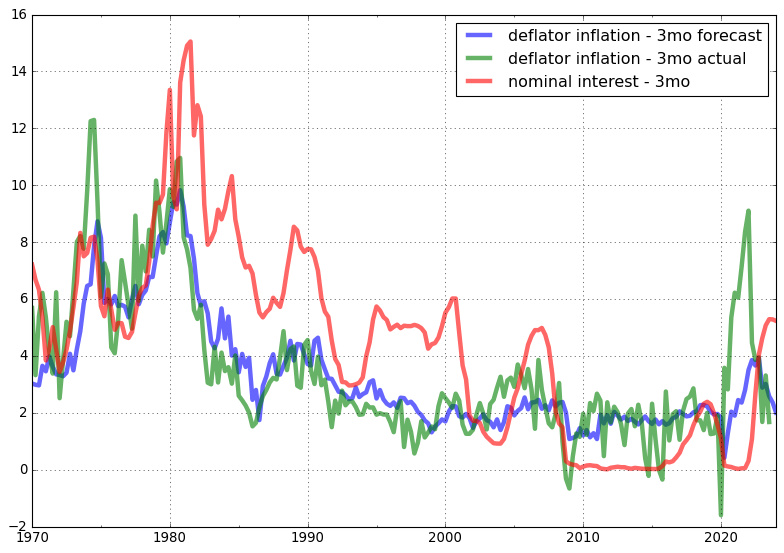

In [11]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
full_data_frame[['deflator inflation - 3mo forecast','deflator inflation - 3mo actual','nominal interest - 3mo'
                ]].plot(ax=ax,lw=4,alpha = 0.6,grid=True)

In [12]:
# Construct annual data and export

# Resample to annual freq and count occurences per year
annual_data_frame = full_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','nominal interest - 1yr'
                ]].resample('AS').mean().dropna()

# Export to csv
annual_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','nominal interest - 1yr'
                ]].to_csv('../csv/real_rate_data_A.csv')

<Axes: >

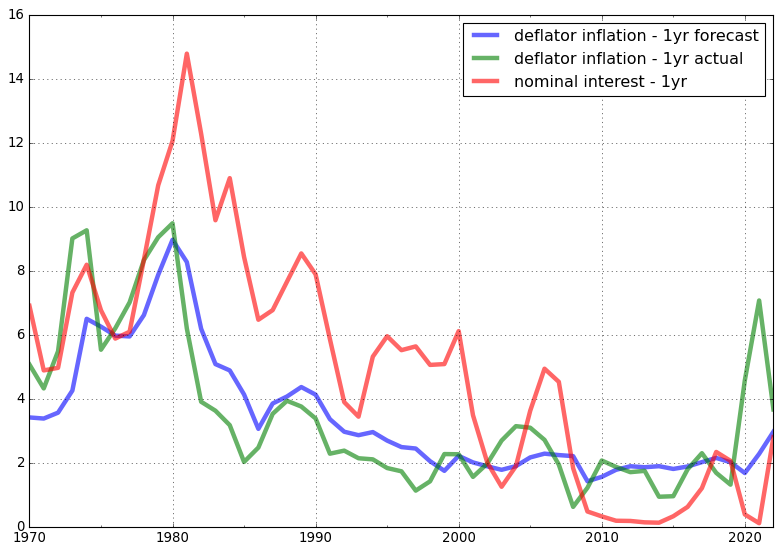

In [13]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
annual_data_frame.plot(ax=ax,lw=4,alpha = 0.6,grid=True)

## Figure for website

In [14]:
# Formatter for inserting commas in y axis labels with magnitudes in the thousands

# Make all plotted axis lables and tick lables bold 15 pt font
font = {#'weight' : 'bold',
        'size'   : 15}
axes={'labelweight' : 'bold'}
plt.rc('font', **font)
plt.rc('axes', **axes)

# Add some space around the tick lables for better readability
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'


def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = plt.FuncFormatter(func)  # make formatter

# format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


# y label locator for vertical axes plotting gdp
majorLocator_y   = plt.MultipleLocator(3)
majorLocator_shares   = plt.MultipleLocator(0.2)

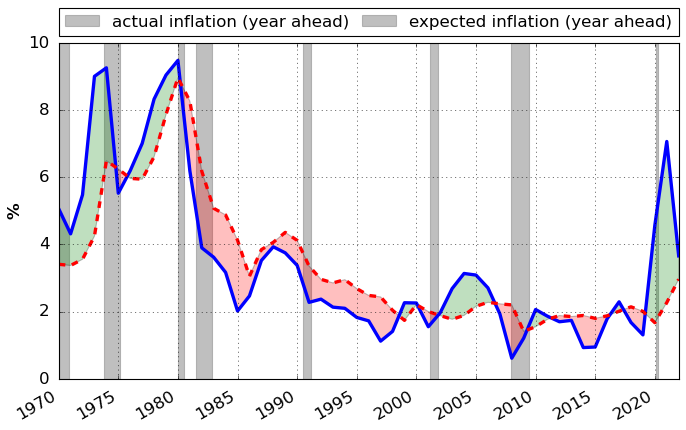

In [15]:
# Figure

expectedInflation = annual_data_frame['deflator inflation - 1yr forecast']
actualInflation = annual_data_frame['deflator inflation - 1yr actual']

v =fp.to_fred_series(data = annual_data_frame['deflator inflation - 1yr actual'],dates=annual_data_frame.index)

fig=plt.figure(figsize=(10, 6))
ax=fig.add_subplot(1,1,1)
v.recessions()
ax.plot_date(annual_data_frame.index,actualInflation,'b-',lw=3)
ax.plot_date(annual_data_frame.index,expectedInflation,'r--',lw=3)
ax.fill_between(annual_data_frame.index,actualInflation, expectedInflation, where = expectedInflation<actualInflation,alpha=0.25,facecolor='green', interpolate=True)
ax.fill_between(annual_data_frame.index,actualInflation, expectedInflation, where = expectedInflation>actualInflation,alpha=0.25,facecolor='red', interpolate=True)
ax.set_ylabel('%')
ax.xaxis.set_major_locator(years5)
ax.legend(['actual inflation (year ahead)','expected inflation (year ahead)'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,prop={'weight':'normal','size':'15'})
plt.grid()
fig.autofmt_xdate()
plt.savefig('../png/fig_US_Inflation_Forecast_site.png',bbox_inches='tight')

In [16]:
## Delete SPF data files

In [17]:
try:
    os.remove('../xlsx/inflation.xlsx')
except:
    pass